In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from benchmark import benchmark_ns
import torch as t
from pycuda_utils import Holder, load_module, ceil_divide
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Benchmark sum_atomic

In [49]:
sum_atomic = load_module("sum_atomic.cu").get_function("sum")

def benchmark_sum_ns(size: int, num_iters: int) -> float:
    arr = t.randn(size, dtype=t.float32).cuda()
    total = t.zeros(1, dtype=t.float32).cuda()

    def fn():
        sum_atomic(
            Holder(arr),
            np.uint32(size),
            Holder(total),
            block=(512, 1, 1),
            grid=(int(ceil_divide(size, 512)), 1),
        )

    return benchmark_ns(fn, num_iters)


### Benchmark sum_rows

In [52]:
sum_rows = load_module("sum_rows.cu").get_function("sum_rows")

counter = 0

num_cols = np.uint32(10)
num_rows = np.uint32(2000)

def benchmark_sum_rows_ns(num_iters: int, num_cols: int, num_rows: int) -> float:
    src = t.randn((num_cols, num_rows), dtype=t.float32).cuda()
    dst = t.zeros(num_cols, dtype=t.float32).cuda()

    src = src.contiguous()
    dst = dst.contiguous()

    def fn():
        sum_rows(
            Holder(src),
            Holder(dst),
            np.uint32(num_cols),
            np.uint32(num_rows),
            block=(1024, 1, 1),
            grid=(int(ceil_divide(num_cols, 1024)), 1),
        )

    return benchmark_ns(fn, num_iters)


In [54]:
benchmark_sum_rows_ns(10, 100_000, 10)

43157.0

In [55]:
benchmark_sum_rows_ns(10, 10, 100_000)

7766471.8

### Fast sum_array

In [77]:
from sum_shared import shared_sum


def benchmark_sum_shared(size: int, num_iters: int) -> float:
    arr = t.randn(size, dtype=t.float32).cuda()

    def fn():
        shared_sum(arr)

    return benchmark_ns(fn, num_iters)


def benchmark_sum_pytorch(size: int, num_iters: int) -> float:
    arr = t.randn(size, dtype=t.float32).cuda()

    def fn():
        arr.sum()

    return benchmark_ns(fn, num_iters)


In [72]:
STATS = {
    "sizes" : np.array([10 ** n for n in range(10)])
}

In [73]:
STATS["slow_sum"] = [benchmark_sum_ns(size, 10) for size in tqdm(STATS["sizes"])]

100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


In [74]:
STATS["fast_sum"] = [benchmark_sum_shared(size, 10) for size in tqdm(STATS["sizes"])]

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [78]:
STATS["pytorch_sum"] = [benchmark_sum_pytorch(size, 10) for size in tqdm(STATS["sizes"])]




100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


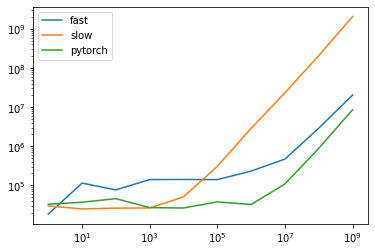

In [80]:
plt.plot(STATS["sizes"], STATS["fast_sum"], label = "fast")
plt.plot(STATS["sizes"], STATS["slow_sum"], label = "slow")
plt.plot(STATS["sizes"], STATS["pytorch_sum"], label = "pytorch")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [82]:
print(np.array(STATS["pytorch_sum"]) / np.array(STATS["fast_sum"]))

[1.7910993  0.32498566 0.59528467 0.1921165  0.18618612 0.26983595
 0.13985123 0.23114833 0.30524273 0.42112509]
